In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

# Load and preprocess
df = pd.read_csv('/content/train.csv')
df = df.dropna()  # Drop missing rows (or impute)
df = df.drop(columns=['id'])  # Drop irrelevant column



In [28]:
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [29]:
# Feature engineering
df['temp_range'] = df['maxtemp'] - df['mintemp']
df['dewpoint_diff'] = df['temparature'] - df['dewpoint']
df['month'] = np.ceil(df['day'] / 30.5).astype(int)

# EDA (example: check rainfall distribution)
print(df['rainfall'].value_counts(normalize=True))



rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [5]:
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,temp_range,dewpoint_diff,month
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1.3,1.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0.4,1.5,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,4.8,6.8,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,1.2,1.0,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,6.1,8.8,1


Rainfall Distribution (%):
rainfall
1    75.342466
0    24.657534
Name: proportion, dtype: float64


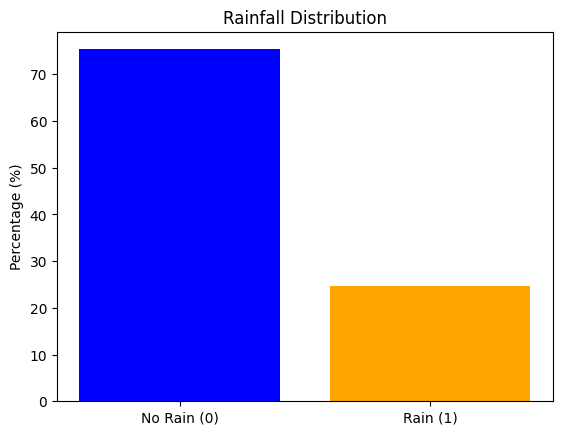

In [6]:
import matplotlib.pyplot as plt

# Rainfall distribution
rainfall_counts = df['rainfall'].value_counts(normalize=True) * 100
print("Rainfall Distribution (%):")
print(rainfall_counts)

# Bar plot
plt.bar(['No Rain (0)', 'Rain (1)'], rainfall_counts, color=['blue', 'orange'])
plt.title('Rainfall Distribution')
plt.ylabel('Percentage (%)')
plt.show()

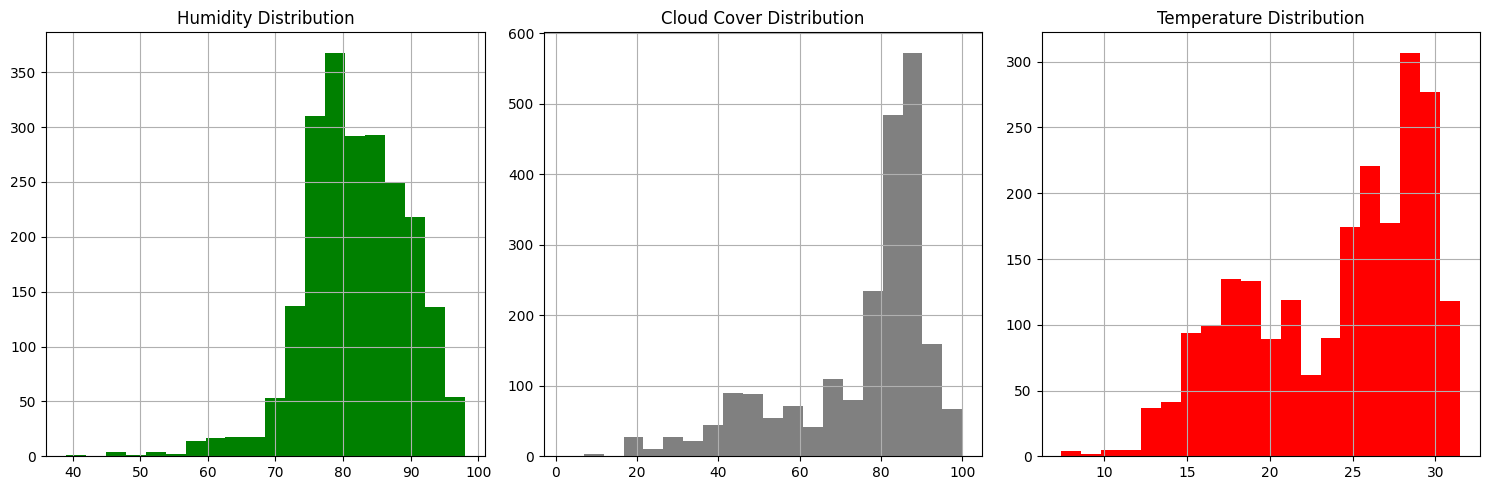

In [7]:
# Histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df['humidity'].hist(ax=axes[0], bins=20, color='green')
axes[0].set_title('Humidity Distribution')
df['cloud'].hist(ax=axes[1], bins=20, color='gray')
axes[1].set_title('Cloud Cover Distribution')
df['temparature'].hist(ax=axes[2], bins=20, color='red')
axes[2].set_title('Temperature Distribution')
plt.tight_layout()
plt.show()

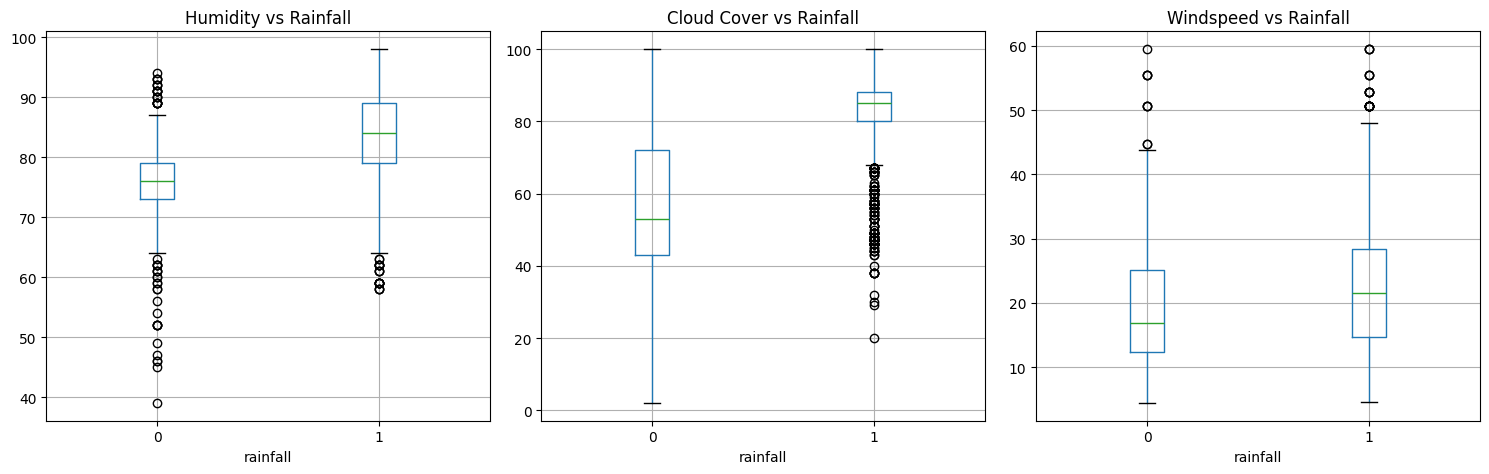

In [8]:
# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df.boxplot(column='humidity', by='rainfall', ax=axes[0])
axes[0].set_title('Humidity vs Rainfall')
df.boxplot(column='cloud', by='rainfall', ax=axes[1])
axes[1].set_title('Cloud Cover vs Rainfall')
df.boxplot(column='windspeed', by='rainfall', ax=axes[2])
axes[2].set_title('Windspeed vs Rainfall')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

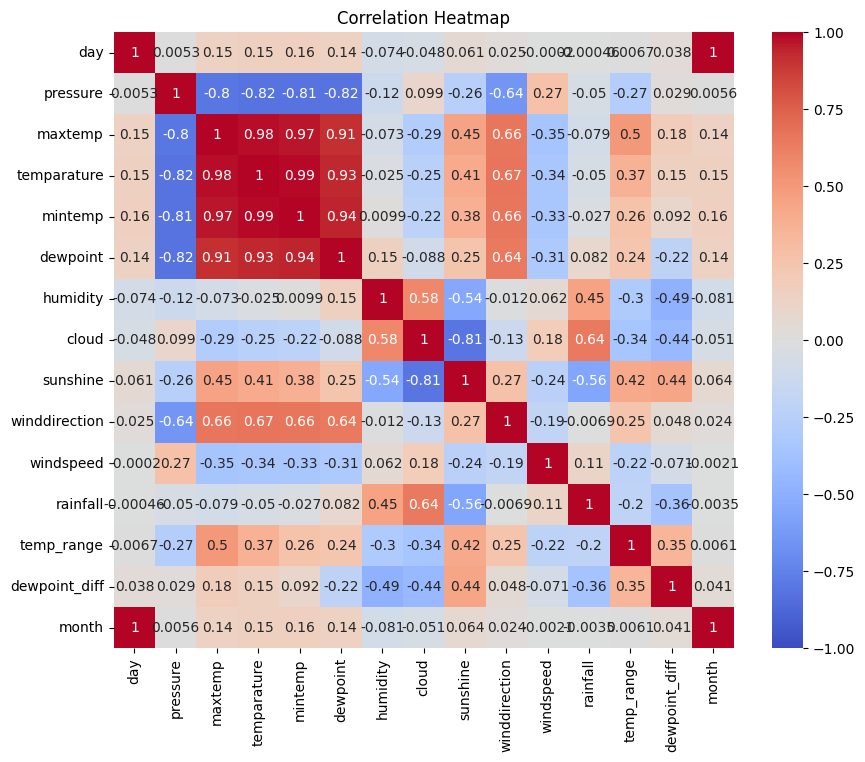

In [9]:
import seaborn as sns

# Correlation matrix
corr = df.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [30]:
# Split data
X = df.drop(columns=['rainfall'])
y = df['rainfall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [31]:
# Base models
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
svm = SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True, random_state=42)

# Fit base models
rf.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)



SVC(class_weight='balanced', probability=True, random_state=42)

In [32]:
# Stacking: predictions for meta-model
rf_preds_train = rf.predict_proba(X_train_scaled)[:, 1]
svm_preds_train = svm.predict_proba(X_train_scaled)[:, 1]
stacked_train = np.column_stack((rf_preds_train, svm_preds_train))

# Meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train)



LogisticRegression()

In [34]:
# Test predictions
rf_preds_test = rf.predict_proba(X_test_scaled)[:, 1]
svm_preds_test = svm.predict_proba(X_test_scaled)[:, 1]
stacked_test = np.column_stack((rf_preds_test, svm_preds_test))
final_preds = meta_model.predict(stacked_test)

# Evaluate
print("F1 Score:", f1_score(y_test, final_preds))
print("AUC-ROC:", roc_auc_score(y_test, meta_model.predict_proba(stacked_test)[:, 1]))

F1 Score: 0.9112081513828238
AUC-ROC: 0.8580808080808081


In [43]:
# Load and preprocess
df_test = pd.read_csv('/content/test.csv')
test_ids = df_test['id']

df_test = df_test.drop(columns=['id'])  # Drop irrelevant column


# Feature engineering
df_test['temp_range'] = df_test['maxtemp'] - df_test['mintemp']
df_test['dewpoint_diff'] = df_test['temparature'] - df_test['dewpoint']
df_test['month'] = np.ceil(df_test['day'] / 30.5).astype(int)






In [44]:

# Prepare test data
X_test_new = df_test
X_test_new = X_test_new.fillna(method='ffill')
X_test_new_scaled = scaler.transform(X_test_new)

# Get predictions from base models
rf_preds_test_new = rf.predict_proba(X_test_new_scaled)[:, 1]
svm_preds_test_new = svm.predict_proba(X_test_new_scaled)[:, 1]

# Stack predictions
stacked_test_new = np.column_stack((rf_preds_test_new, svm_preds_test_new))



<ipython-input-44-0f376c19c676>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test_new = X_test_new.fillna(method='ffill')


In [45]:
# Predict rainfall using meta-model

final_preds_proba_new = meta_model.predict_proba(stacked_test_new)[:, 1]
final_preds_proba_new = np.round(final_preds_proba_new, 4)

# Create a DataFrame with predictions
df_submission = pd.DataFrame({'id': test_ids, 'rainfall': final_preds_proba_new})

# Save to CSV
df_submission.to_csv('submission1.csv', index=False)